
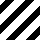
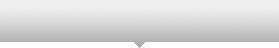
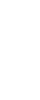
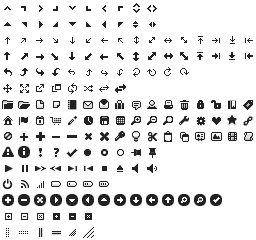
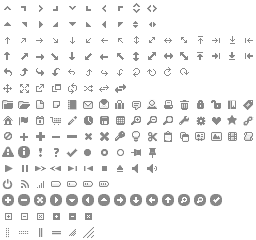
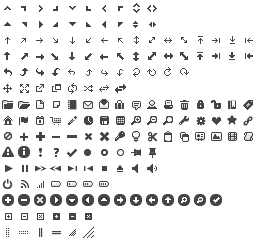
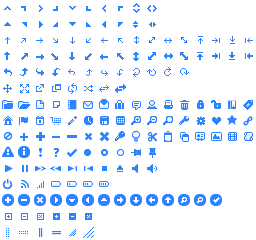
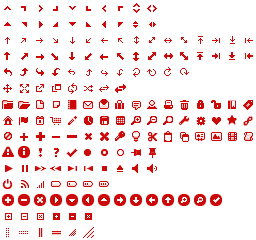
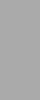
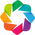
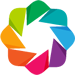
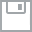
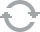
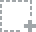
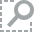
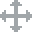
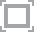
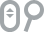

In [1]:
import sys
import getopt
import collections
import random

import numpy as np

import matplotlib.pyplot as plt
from bokeh import mpl
from bokeh.plotting import output_notebook, show

from space import Space
from utils import read_dict, train_tm, apply_tm, score, get_valid_data

from tsne import bh_sne

import csv
import codecs

from gensim.models import Word2Vec

output_notebook()

### Load models 

In [ ]:
model_nl = Word2Vec.load_word2vec_format('models/nlwiki_lowercase.model', binary=False)  # C text format
# model_nl = Word2Vec.load_word2vec_format('models/nlwiki_lowercase_400.model', binary=False)  # C text format

In [ ]:
# model_en = Word2Vec.load_word2vec_format('models/enwiki_lowercase_400.model', binary=False, encoding='latin1')  # C text format
model_en = Word2Vec.load_word2vec_format('models/enwiki_lowercase.model', binary=False, encoding='latin1')  # C text format

In [ ]:
model_both = Word2Vec.load_word2vec_format('models/bothwiki_400.model', binary=False, encoding='latin1')  # C text format

### Train and test translation matrix

In [24]:
dutch_file = 'dutch2.txt'

def top_translations(w, translation_matrix, topn=5):
#     vec = translation_matrix.dot(model_nl[w])
    vec = model_nl[w].dot(translation_matrix)
    
    return model_en.most_similar([vec], topn=topn)

def get_rank(nn, gold):
    for idx, word in enumerate(nn):
        if word in gold:
            return idx + 1
    return idx + 1


# print out source word and translation
def display_translations(pairs, training_size=1500, topn=[1, 5, 10], printing=True):
    train_data = read_dict(dutch_file)
    word_pairs = codecs.open('did_it_work.csv', 'r', 'utf-8')

    dic2 = pd.read_csv(word_pairs, sep=';', header=None, names=['en', 'nl', 'drop', 'drop', 'drop', 'drop', 'drop'])[['en', 'nl']]


    # we only need to load the vectors for the words in the training data
    # semantic spaces contain additional words
    source_words, target_words = zip(*train_data)

    vectors_source = []
    vectors_target = []

    pairs = {}

    for nl, en in train_data:
        if nl in model_nl and en in model_en:
            if nl in pairs and en not in pairs[nl]['target']:
                pairs[nl]['target'].append(en)
                pairs[nl]['target_vec'].append(model_en[en])
            elif nl not in pairs:
                pairs[nl] = {}
                pairs[nl]['vec'] = model_nl[nl]
                pairs[nl]['training'] = False
                pairs[nl]['target'] = [en]
                pairs[nl]['target_vec'] = [model_en[en]]


    for n in range (len(dic2)):
        nl = dic2['nl'][n]
        en = dic2['en'][n]

        if nl in model_nl and en in model_en:      
            if nl in pairs and en not in pairs[nl]['target']:
                pairs[nl]['target'].append(en)
                pairs[nl]['target_vec'].append(model_en[en])
            elif nl not in pairs:
                pairs[nl] = {}
                pairs[nl]['vec'] = model_nl[nl]
                pairs[nl]['training'] = False
                pairs[nl]['target'] = [en]
                pairs[nl]['target_vec'] = [model_en[en]]

    # print len(vectors_source)

    matrix_train_source = []
    matrix_train_target = []
    count = 0
    for key, value in pairs.iteritems(): 
        if count < training_size and value['target']:
            matrix_train_source.append(value['vec'])
            matrix_train_target.append(value['target_vec'][0])
            value['training'] = True
            count = count + 1

    # matrix_train_source = pd.DataFrame([s[1] for s in vectors_source]).values[:3500]
    # matrix_train_target = pd.DataFrame([s[1] for s in vectors_target]).values[:3500]

    if printing:
        print 'Generating translation matrix'

    # Matrix W is given in  http://stackoverflow.com/questions/27980159/fit-a-linear-transformation-in-python
    # translation_matrix = np.linalg.pinv(matrix_train_source).dot(matrix_train_target).T
    translation_matrix = np.linalg.lstsq(matrix_train_source, matrix_train_target, -1)[0]
    if printing:
        print 'Generated translation matrix'
    
    
    correct = np.zeros(len(topn))
    test = 0
    topn.sort()
    for key, value in pairs.iteritems(): 
        if not value['training']:
            test = test + 1
            source_word = key
            target_words = value['target']

            if printing:
                print 'source: %s, real translation: %s' % (source_word, target_words)

            translations = top_translations(source_word, translation_matrix, topn[len(topn)-1]) # check for largest element in the list

            if printing:
                print translations
            
            for i, n in enumerate(topn):
                if True in [target_word in [t[0] for t in translations[:n]] for target_word in target_words]:
                    correct[i] = correct[i] + 1
    
    accuracy = [c / test for c in correct]
        
    return accuracy

accuracies = {}
for i in range(500, 3000, 100):
    accuracies[i] = display_translations(pairs, training_size=i, printing=False)
    print "Training Size: %s, Accuracy @1, 5, 10: %s" % (i, accuracies[i])

Training Size: 500, Accuracy @1, 5, 10: [0.3830203442879499, 0.55790297339593109, 0.61502347417840375]
Training Size: 600, Accuracy @1, 5, 10: [0.3965798045602606, 0.56921824104234531, 0.63273615635179148]
Training Size: 700, Accuracy @1, 5, 10: [0.41893039049235992, 0.58531409168081494, 0.64261460101867574]
Training Size: 800, Accuracy @1, 5, 10: [0.42375886524822692, 0.59042553191489366, 0.64849290780141844]
Training Size: 900, Accuracy @1, 5, 10: [0.43320964749536178, 0.60111317254174401, 0.65816326530612246]
Training Size: 1000, Accuracy @1, 5, 10: [0.43433852140077822, 0.60700389105058361, 0.66293774319066145]
Training Size: 1100, Accuracy @1, 5, 10: [0.43967280163599182, 0.6073619631901841, 0.66462167689161555]
Training Size: 1200, Accuracy @1, 5, 10: [0.43534482758620691, 0.61153017241379315, 0.66918103448275867]
Training Size: 1300, Accuracy @1, 5, 10: [0.43223234624145784, 0.60990888382687924, 0.65945330296127558]
Training Size: 1400, Accuracy @1, 5, 10: [0.43538647342995168, 

In [46]:
word_pairs = codecs.open('did_it_work.csv', 'r', 'utf-8')

pairs = pd.read_csv(word_pairs, sep=';', header=None, names=['en', 'nl', 'drop', 'drop', 'drop', 'drop', 'drop'])[['en', 'nl']]

pairs

,en,nl
0,a,een
1,ability,vermogen
2,accent,accent
3,ace!,tof!
4,activity,activiteit
5,ago,geleden
6,airport,vliegveld
7,album,album
8,alligator,alligator
9,always,altijd


In [3]:
source_sp.mat[1:10]
vec_2d = bh_sne(source_sp.mat[1:100])

vec_2d

array([[-0.9899, -2.1206],
       [ 3.2677, -5.585 ],
       [-3.8003,  0.3604],
       [-0.6878, -1.5185],
       [-0.0621,  1.3819],
       [-2.0825, -1.6609],
       [-0.3404, -2.099 ],
       [-1.6439,  4.1815],
       [-1.387 ,  1.1259],
       [-4.3078, -0.3199],
       [-2.5878,  4.709 ],
       [-1.3709,  0.9511],
       [-3.9089, -2.6588],
       [-0.4136, -2.5228],
       [-0.622 , -5.6329],
       [-5.3457, -5.3581],
       [-0.6787, -5.546 ],
       [-0.2176, -3.3926],
       [ 1.533 , -5.942 ],
       [-5.2532,  0.2371],
       [-1.9742,  5.4261],
       [ 2.0456, -2.4552],
       [ 1.4415, -4.5469],
       [ 4.9373, -1.2118],
       [-5.6683, -0.4583],
       [-2.1141,  0.9372],
       [ 0.351 , -0.5427],
       [-5.0138, -2.049 ],
       [-4.5485,  0.0891],
       [-3.63  ,  2.3499],
       [-2.3662, -2.0764],
       [ 2.5735, -3.5438],
       [-2.1506, -0.5421],
       [-1.5557,  4.0754],
       [-5.4306, -5.4965],
       [ 4.1816,  2.5029],
       [-2.7989,  3.1696],
 

In [16]:
def create_plot_2d_speeches(withLabels=True):
    if withLabels:
        font = { 'fontname':'Tahoma', 'fontsize':8, 'verticalalignment': 'top', 'horizontalalignment':'center' }
        labels= source_sp.id2row[1:100]
        plt.subplots_adjust(bottom =0.1)
        vec_2d = bh_sne(source_sp.mat[1:100])
        plt.scatter(vec_2d[:,0], vec_2d[:,1], cmap = pylab.get_cmap('Spectral'))
        for label, x, y in zip(labels, vec_2d[:, 0], vec_2d[:, 1]):
            plt.annotate(
                label, 
                xy = (x, y), xytext = None,
                ha = 'right', va = 'bottom', **font)
                #,textcoords = 'offset points',bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

        plt.title('Dutch-English Multimodel')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        show(mpl.to_bokeh())

#         pylab.show('plot_with_labels', bbox_inches ='tight', dpi = 1000, orientation = 'landscape', papertype = 'a0')
    else:
        pylab.subplots_adjust(bottom =0.1)
        pylab.scatter(self.speech_2d[:,0], self.speech_2d[:,1], marker = 'o' ,cmap = pylab.get_cmap('Spectral'))
        pylab.title('U.S. Presidential Speeches(1790-2006)')
        pylab.xlabel('X')
        pylab.ylabel('Y')
        pylab.savefig('plot_without_labels', bbox_inches ='tight', dpi = 1000, orientation = 'landscape', papertype = 'a0')
#     pylab.close()

create_plot_2d_speeches()

In [20]:
maanden = ['januari', 'februari', 'maart', 'april', 'mei', 'juni', 'juli', 'augustus', 'september', 'oktober', 'november', 'december']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

tellen = ['een', 'twee', 'drie', 'vier', 'vijf', 'zes', 'zeven', 'acht', 'negen', 'tien', 'twintig', 'dertig', 'veertig', 'vijftig', 'zestig', 'zeventig', 'tachtig', 'negentig', 'honderd']
counting = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'twenty', 'thirty', 'fourty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 'hundred']

dieren = ['hond', 'kat', 'paard', 'ezel', 'vis', 'varken']
animals = ['dog', 'cat', 'horse', 'donkey', 'fish', 'pig']

mannelijk_vrouwlijk = ['koning', 'koningin', 'man', 'vrouw', 'mannelijk', 'vrouwlijk', 'echtgenoot', 'echtgenote']
male_female =['king', 'queen', 'man', 'woman', 'male', 'female', 'husband', 'wife']

kleuren = ['zwart', 'wit', 'rood', 'blauw', 'geel', 'paars', 'roze', 'oranje', 'green']
colors = ['black', 'white', 'red', 'blue', 'yellow', 'purple', 'pink', 'orange', 'green']

model_nl.most_similar(positive=['vrouw', 'koning'], negative=['man'])

for i in range(0, 100):
    maanden.append(str(i))
    months.append(str(i))
    tellen.append(str(i))
    counting.append(str(i))
    dieren.append(str(i))
    animals.append(str(i))
    mannelijk_vrouwlijk.append(str(i))
    male_female.append(str(i))
    kleuren.append(str(i))
    colors.append(str(i))

counting

['one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine',
 'ten',
 'twenty',
 'thirty',
 'fourty',
 'fifty',
 'sixty',
 'seventy',
 'eighty',
 'ninety',
 'hundred',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [13]:
def create_plot_2d_speeches(labels, model, title):
    font = { 'fontname':'Tahoma', 'fontsize':8, 'verticalalignment': 'top', 'horizontalalignment':'center' }
    vectors = np.asarray([model[label] for label in labels if label in model], dtype=np.float64)
#     .astype(np.float64, copy=False)
#     print vectors.astype(np.float64, copy=False)
    plt.subplots_adjust(bottom=0.1)
    vec_2d = bh_sne(vectors)
    plt.scatter(vec_2d[:,0], vec_2d[:,1], cmap = plt.get_cmap('Spectral'))
    for label, x, y in zip(labels, vec_2d[:, 0], vec_2d[:, 1]):
        plt.annotate(
            label, 
            xy = (x, y), xytext = None,
            ha = 'right', va = 'bottom', **font)
            #,textcoords = 'offset points',bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')

    show(mpl.to_bokeh())

#   pylab.show('plot_with_labels', bbox_inches ='tight', dpi = 1000, orientation = 'landscape', papertype = 'a0')

create_plot_2d_speeches(tellen, model_nl, 'Dutch Model')

In [14]:
create_plot_2d_speeches(counting, model_en, 'English Model')

In [17]:
create_plot_2d_speeches(dieren, model_nl, 'Dutch Animals')
create_plot_2d_speeches(animals, model_en, 'English Animals')

In [19]:
create_plot_2d_speeches(mannelijk_vrouwlijk, model_nl, 'Dutch Male-Female')
create_plot_2d_speeches(male_female, model_en, 'English Male-Female')

In [21]:
create_plot_2d_speeches(kleuren, model_nl, 'Dutch Colors')
create_plot_2d_speeches(colors, model_en, 'English Colors')

In [24]:
merged_colors = set(kleuren + colors)
create_plot_2d_speeches(merged_colors, model_both, 'Merged Colors')

In [26]:
merged_malefemale = set(mannelijk_vrouwlijk + male_female)
create_plot_2d_speeches(merged_malefemale, model_both, 'Merged Male-Female')

In [28]:
model_both.most_similar('vrouw')

[(u'vrouw,', 0.8842492699623108),
 (u'echtgenote', 0.8276942372322083),
 (u'moeder', 0.8137116432189941),
 (u'dochter', 0.7567077875137329),
 (u'zus', 0.7329782247543335),
 (u'vader', 0.7320223450660706),
 (u'zuster', 0.727215588092804),
 (u'moeder,', 0.7201077938079834),
 (u'weduwe', 0.7154377698898315),
 (u'echtgenoot', 0.7127014398574829)]

In [29]:
model_nl.most_similar('vrouw')

[(u'vrouw,', 0.8622430562973022),
 (u'echtgenote', 0.7370803952217102),
 (u'moeder', 0.6797406673431396),
 (u'echtgenote,', 0.6644330024719238),
 (u'weduwe', 0.6362216472625732),
 (u'vrouw.', 0.6348034143447876),
 (u'ex-vrouw', 0.6111721396446228),
 (u'schoonmoeder', 0.6096578240394592),
 (u'echtgenoot', 0.6093814373016357),
 (u'weduwe,', 0.6002705693244934)]

In [32]:
model_both.most_similar(positive=['vrouw', 'king'], negative=['man'])

[(u'echtgenote', 0.5757095813751221),
 (u'koningin', 0.5020423531532288),
 (u'dochter', 0.500700831413269),
 (u'vrouw,', 0.49203789234161377),
 (u'koning', 0.4839927554130554),
 (u'echtgenote,', 0.47034358978271484),
 (u'prinses', 0.4645093083381653),
 (u'moeder', 0.46382999420166016),
 (u'zuster', 0.45372313261032104),
 (u'weduwe', 0.4515072703361511)]

In [3]:
model_en.vocab

{u'Dholes': <gensim.models.word2vec.Vocab at 0x2828c8c10>,
 u'("Second': <gensim.models.word2vec.Vocab at 0x26c5cd6d0>,
 u'Auksciausia': <gensim.models.word2vec.Vocab at 0x2841a1910>,
 u'Kangpokpi': <gensim.models.word2vec.Vocab at 0x28d888650>,
 u'FitzStephen,': <gensim.models.word2vec.Vocab at 0x2a3376950>,
 u'(stone)': <gensim.models.word2vec.Vocab at 0x274426c50>,
 u'(stone,': <gensim.models.word2vec.Vocab at 0x288085cd0>,
 u'"Marketing",': <gensim.models.word2vec.Vocab at 0x2d3d06850>,
 u'"gallus",': <gensim.models.word2vec.Vocab at 0x2d1ccef50>,
 u'(TMX)': <gensim.models.word2vec.Vocab at 0x2d087d8d0>,
 u'GP=Games': <gensim.models.word2vec.Vocab at 0x2b195fb50>,
 u'"Balao"': <gensim.models.word2vec.Vocab at 0x26edb2b50>,
 u'Eury': <gensim.models.word2vec.Vocab at 0x27ca09c90>,
 u'Greenson': <gensim.models.word2vec.Vocab at 0x27e4e7f10>,
 u'dosimetry.': <gensim.models.word2vec.Vocab at 0x2800077d0>,
 u'dosimetry,': <gensim.models.word2vec.Vocab at 0x27ecfc410>,
 u'Marie-Dominique-

In [5]:
len(model_nl.vocab)

953099